In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/traffic_data.csv", nrows=100000, quotechar='"')
print("Shape:", df.shape)
df.head()

Shape: (100000, 87)


,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,26/04/201711:11:17,45523,22,55,...,0.0,0,0,0.0,0.0,0,0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,26/04/201711:11:17,1,2,0,...,0.0,0,0,0.0,0.0,0,0,BENIGN,131,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,...,0.0,0,0,0.0,0.0,0,0,BENIGN,7,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,...,0.0,0,0,0.0,0.0,0,0,BENIGN,7,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,26/04/201711:11:17,78068,5,0,...,0.0,0,0,0.0,0.0,0,0,BENIGN,131,HTTP_PROXY


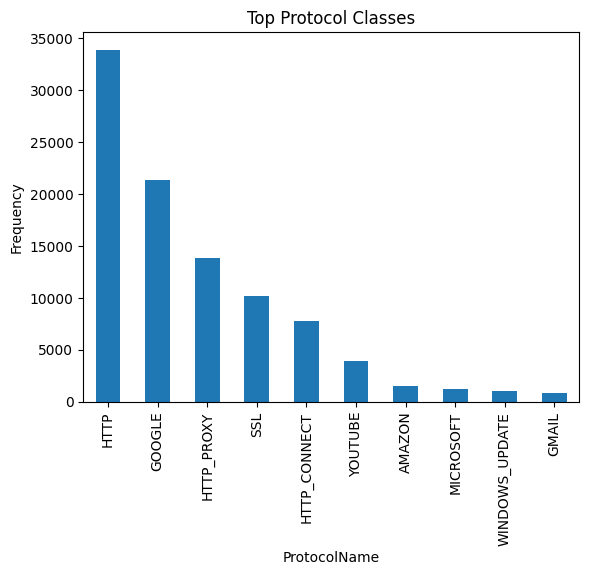

In [3]:
df['ProtocolName'].value_counts().head(10).plot(kind='bar', title='Top Protocol Classes')
plt.ylabel("Frequency")
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

top_classes = df['ProtocolName'].value_counts().head(5).index.tolist()
df = df[df['ProtocolName'].isin(top_classes)]
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df = df.sample(n=min(len(df), 10000), random_state=42)

print("Sampled size:", df.shape)
display(df.head())  

y = df['ProtocolName']
X = df.drop(columns=[
    'ProtocolName', 'Flow.ID', 'Source.IP', 'Destination.IP', 'Timestamp', 'Label'
], errors='ignore')
X = X.select_dtypes(include=[np.number])

print("Final feature types:\n", X.dtypes.value_counts())
le = LabelEncoder()
y_encoded = le.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Sampled size: (10000, 87)


,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
75494,192.168.72.51-10.200.7.5-7783-3128-6,10.200.7.5,3128,192.168.72.51,7783,6,26/04/201711:16:17,253,1,1,...,0.0,0,0,0.0,0.0,0,0,BENIGN,7,HTTP
35265,149.56.163.142-10.200.7.195-443-34358-6,10.200.7.195,34358,149.56.163.142,443,6,26/04/201711:14:08,2468272,29,62,...,0.0,0,0,0.0,0.0,0,0,BENIGN,91,SSL
22132,192.168.180.67-10.200.7.8-48342-3128-6,10.200.7.8,3128,192.168.180.67,48342,6,26/04/201711:13:19,205,2,0,...,0.0,0,0,0.0,0.0,0,0,BENIGN,7,HTTP
85117,10.200.7.7-10.230.1.155-3128-56940-6,10.230.1.155,56940,10.200.7.7,3128,6,26/04/201711:14:43,942,3,0,...,0.0,0,0,0.0,0.0,0,0,BENIGN,130,HTTP_CONNECT
19823,192.168.10.20-10.200.7.6-2933-3128-6,192.168.10.20,2933,10.200.7.6,3128,6,26/04/201711:12:57,10409766,7,25,...,0.0,0,0,0.0,0.0,0,0,BENIGN,126,GOOGLE


Final feature types:
 int64      53
float64    28
Name: count, dtype: int64


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

      GOOGLE       0.99      0.98      0.98       487
        HTTP       1.00      1.00      1.00       775
HTTP_CONNECT       0.98      0.95      0.96       181
  HTTP_PROXY       0.96      0.99      0.98       321
         SSL       1.00      0.99      0.99       236

    accuracy                           0.99      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



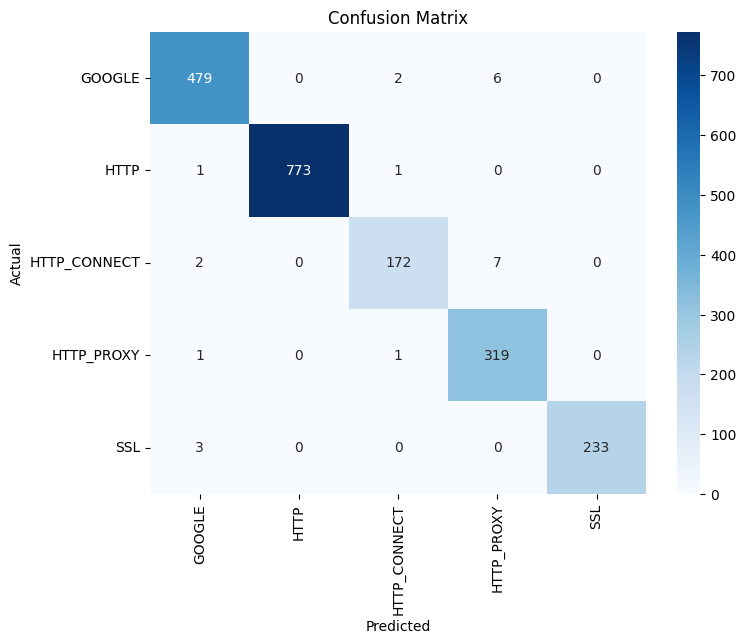

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()